In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_pickle('drive/My Drive/Trabajos/Cursos/Data Science/Experimentos/dataset.pkl')

df = pd.read_pickle('dataset.pkl')
df.head(5)

,property_type,place_name,state_name,geonames_id,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,description,title,zona
0,PH,Mataderos,Capital Federal,3430787.0,-34.661824,-58.508839,62000.00000,55.0,40.0,1127.272727,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,Capital & GBA
2,apartment,Mataderos,Capital Federal,3430787.0,-34.652262,-58.522982,72000.00000,55.0,55.0,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,Capital & GBA
4,apartment,Centro,Buenos Aires Costa Atlántica,3435548.0,-38.002626,-57.549447,64000.00000,35.0,35.0,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,Interior
5,house,Gualeguaychú,Entre Ríos,3433657.0,-33.014071,-58.519828,29724.34828,53.0,NaN,560.836760,NaN,NaN,NaN,http://www.properati.com.ar/15bop_venta_depart...,"Casa en el perímetro del barrio 338, ubicada e...","Casa Barrio 338. Sobre calle 3 de caballería, ...",Interior
6,PH,Munro,Bs.As. G.B.A. Zona Norte,3430511.0,-34.532957,-58.521782,130000.00000,106.0,78.0,1226.415094,NaN,NaN,NaN,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",Capital & GBA


In [3]:
import re
def searchReg(exp):
  return (df['title'].str.contains(exp, case=False, regex=True) | df['description'].str.contains(exp, case=False, regex=True))


def extractCat( exp, catName = False):
  if(catName == False):
    catName = 'has_'+exp
  found = searchReg(exp).astype(int)
  data = df.copy()
  data[catName] = found
  return data

print(extractCat('pileta', 'has_pileta').has_pileta.sum())
print(extractCat('SOLARIUM', 'has_pileta').has_pileta.sum())
print(extractCat('lavadero', 'has_pileta').has_pileta.sum())
print(extractCat('estacionamiento', 'has_pileta').has_pileta.sum())

# df[searchReg('pileta')]
# df[searchReg('SOLARIUM')]
# df[searchReg('lavadero')]
# df[searchReg('estacionamiento')]


14835
6936
29955
1533


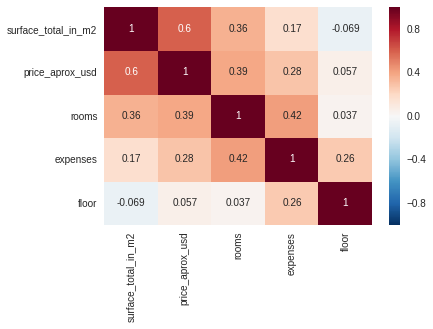

In [15]:
sns.heatmap(df[['surface_total_in_m2', 'price_aprox_usd', 'rooms', 'expenses', 'floor']].corr(), annot=True)
plt.show()

In [72]:
print(len(df))

# df.expenses = df.expenses.fillna(value=0)

cols = ['surface_total_in_m2', 'place_name', 'price_usd_per_m2', 'property_type', 'zona', 'rooms', 'state_name']

print(len(df[cols].dropna()))

data = df[cols].dropna()
data.head(2)

89721
56308


,surface_total_in_m2,place_name,price_usd_per_m2,property_type,zona,rooms,state_name
10,1514.0,Córdoba,46.235139,house,Interior,4.0,Córdoba
13,50.0,Palermo Soho,2234.000000,apartment,Capital & GBA,1.0,Capital Federal


In [73]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=4, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.place_name)
  
y = data.loc[:,['surface_total_in_m2', 'rooms']]

# y = pd.concat( [y, pd.get_dummies(data[['property_type', 'state_name']], drop_first=True)] , axis=1)

x = data['price_usd_per_m2'].values.reshape(-1,1)

y.head()

,surface_total_in_m2,rooms
10,1514.0,4.0
13,50.0,1.0
14,42.0,1.0
15,164.0,4.0
16,140.0,4.0


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)


reg = LinearRegression()
reg.fit(x_train, y_train)

print(reg.score(x_train, y_train))


list(zip(y.columns, reg.coef_))

0.14855131859119908


[('surface_total_in_m2', array([-0.09457951])),
 ('rooms', array([-0.00039029]))]

[[-1.28698383e-14  1.44292089e-14  3.26506363e-14 -3.15291386e-14
   2.75213032e-14  5.86345950e-14  2.77057707e-15]
 [ 1.48642041e-01  1.50991202e-01  1.39045958e-01  1.38772050e-01
   1.44733443e-01  1.51247400e-01  1.48122805e-01]
 [ 2.21424558e-01  2.32306155e-01  2.02920282e-01  2.02021075e-01
   2.11404396e-01  2.21461384e-01  2.16772844e-01]]
[[-2.91417814e-02 -5.46053880e-03 -7.16736321e-05 -6.44290286e-05
  -1.39042937e-02 -4.11115481e-02 -2.40314888e-02]
 [ 1.10726238e-01  1.22640395e-01  1.80490055e-01  1.83193039e-01
   1.44512365e-01  1.15791483e-02  9.16679883e-02]
 [ 1.65823532e-01  4.34901126e-02  2.67629162e-01  2.74026680e-01
   2.24835134e-01  3.65558158e-02  1.45939710e-01]]


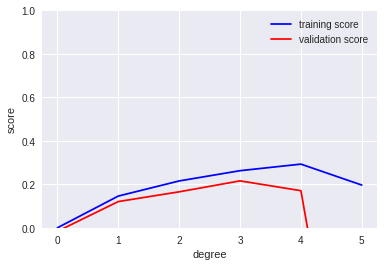

In [76]:
from sklearn.model_selection import validation_curve
grados_a_testear = np.arange(0, 6)
train_score, val_score = validation_curve(PolynomialRegression(), x, y, 'polynomialfeatures__degree'
                                          , grados_a_testear, cv=7) #cv= validacion cruzada, cuanta cantidad quiero

print(train_score[:3])
print(val_score[:3])

plt.plot(grados_a_testear, np.mean(train_score, axis=1), color='blue', label='training score')
plt.plot(grados_a_testear, np.mean(val_score, axis=1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');